# Model validation stations

Note: this notebook requires the model output data

<div class="alert alert-warning" role="alert">
  <strong>⚠️ Important Disclaimer</strong><br><br>
  This model setup is a <strong>simplified version</strong> of a detailed model developed by DHI. It does <strong>not</strong> resolve fine-scale processes and is <strong>not calibrated</strong> for operational use. Use is limited to <strong>educational and research purposes only</strong> — results should <strong>not</strong> inform decision-making. Performance shown here does <strong>not</strong> represent that of DHI’s high-resolution models.
</div>

### Import packages

In [1]:
import modelskill as ms
import matplotlib.pyplot as plt
import helper as h
import plotting as pl
import pandas as pd
from pathlib import Path

### Define paths

In [2]:
obs_fldr = "../observations/" 
mr_fldr = "../output/"    
#mr_fldr = "../output_sample/"     # use this if you have not downloaded the full data from Zenodo yet
mr_fn = f"{mr_fldr}Area.dfsu"

In [3]:
# Load observation data
tplist = h.get_tp_point_obs(station_file="stations_subset.csv")
mwdlist = h.get_mwd_point_obs(station_file="stations.csv")

In [ ]:
# Load MIKE21 simulation data
mr_tp = ms.DfsuModelResult(mr_fn, name="MIKE21", item=1)
mr_dir = ms.DfsuModelResult(mr_fn, name="MIKE21", item=3)

### Create modelskill comparer collection

We consider peak wave period (tp) and mean wave direction (mwd).

In [5]:
# tp
cmps = []
for o in tplist:
    try:
        cmps.append(ms.match(obs=o, mod=mr_tp))
    except Exception as e:
        print(f"Skipping {o.name} due to error: {e}")
        
cc_tp = ms.ComparerCollection(cmps)

In [12]:
# mwd
cmps = []
for o in mwdlist:
    try:
        cmps.append(ms.match(obs=o, mod=mr_dir))
    except Exception as e:
        print(f"Skipping {o.name} due to error: {e}")
        
cc_mwd = ms.ComparerCollection(cmps)

## Skill tables

In [7]:
# Print statistics for the tp-component
cc_tp.skill().round(3)

,n,bias,rmse,urmse,mae,cc,si,r2
observation,,,,,,,,
6201045,31727,0.162,2.221,2.215,1.258,0.757,0.276,0.524
6201047,34867,0.477,2.724,2.682,1.419,0.703,0.339,0.374
6201050,34389,0.912,2.815,2.663,1.613,0.688,0.405,0.286
6201059,34910,0.920,2.781,2.625,1.498,0.490,0.458,-1.045
A121_,10622,1.239,3.200,2.950,1.671,0.534,0.359,-0.531
Europlatform2,102414,0.774,2.266,2.130,1.190,0.505,0.361,-0.676
F3platform,104217,0.438,1.955,1.906,1.002,0.721,0.261,0.319
IJmuidenMunitiestort_,92718,0.598,2.153,2.069,1.166,0.694,0.315,0.256
J61,104343,0.314,1.818,1.790,0.947,0.732,0.258,0.401


In [ ]:
# Print statistics for the mwd-component (use circular metrics)
cc_mwd.skill(metrics=["c_bias", "c_rmse", "c_urmse", "c_mae", "cc", "si", "r2"]).round(3)

,n,c_bias,c_rmse,c_urmse,c_mae,cc,si,r2
observation,,,,,,,,
Europlatform3,8686,2.119,17.276,17.140,9.083,0.675,0.321,0.309
IJmuidenMunitiestort_,101242,5.375,24.858,24.249,13.531,0.749,0.331,0.463
WaddenEierlandseGat,97368,4.499,24.579,24.132,13.392,0.785,0.325,0.567


## Scatter plots

<div class="alert alert-warning" role="alert">
  <strong>⚠️ Important Disclaimer</strong><br><br>
  This model setup is a <strong>simplified version</strong> of a detailed model developed by DHI. It does <strong>not</strong> resolve fine-scale processes and is <strong>not calibrated</strong> for operational use. Use is limited to <strong>educational and research purposes only</strong> — results should <strong>not</strong> inform decision-making. Performance shown here does <strong>not</strong> represent that of DHI’s high-resolution models.
</div>

### Peak wave period

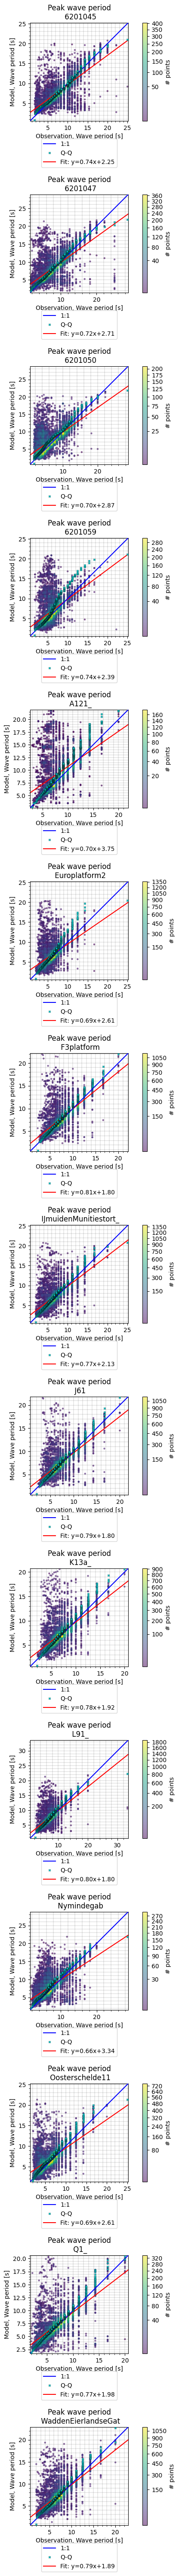

In [9]:
# Scatter plot
pl.plot_scatter_cc(cc = cc_tp, title='Peak wave period')

### Mean wave direction

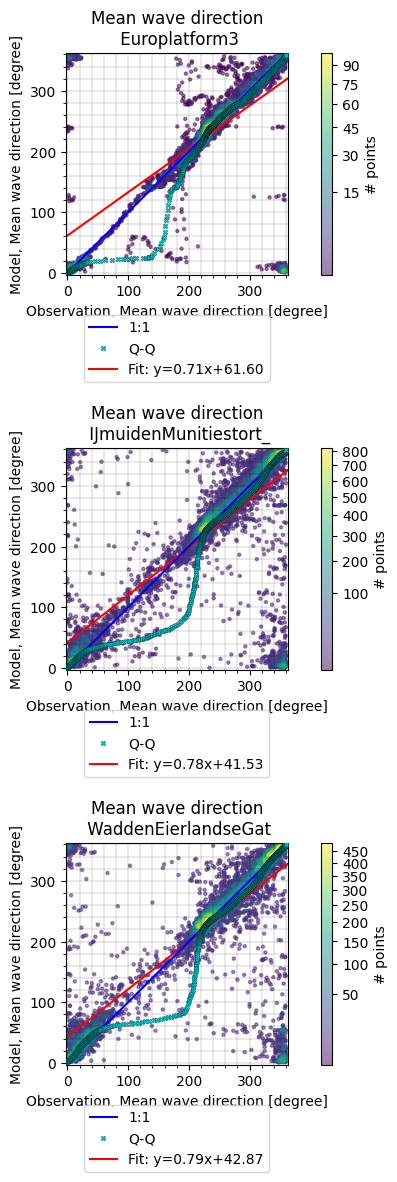

In [ ]:
# Scatter plot
pl.plot_scatter_cc(cc = cc_mwd, title='Mean wave direction')

## Timeseries

### Peak wave period

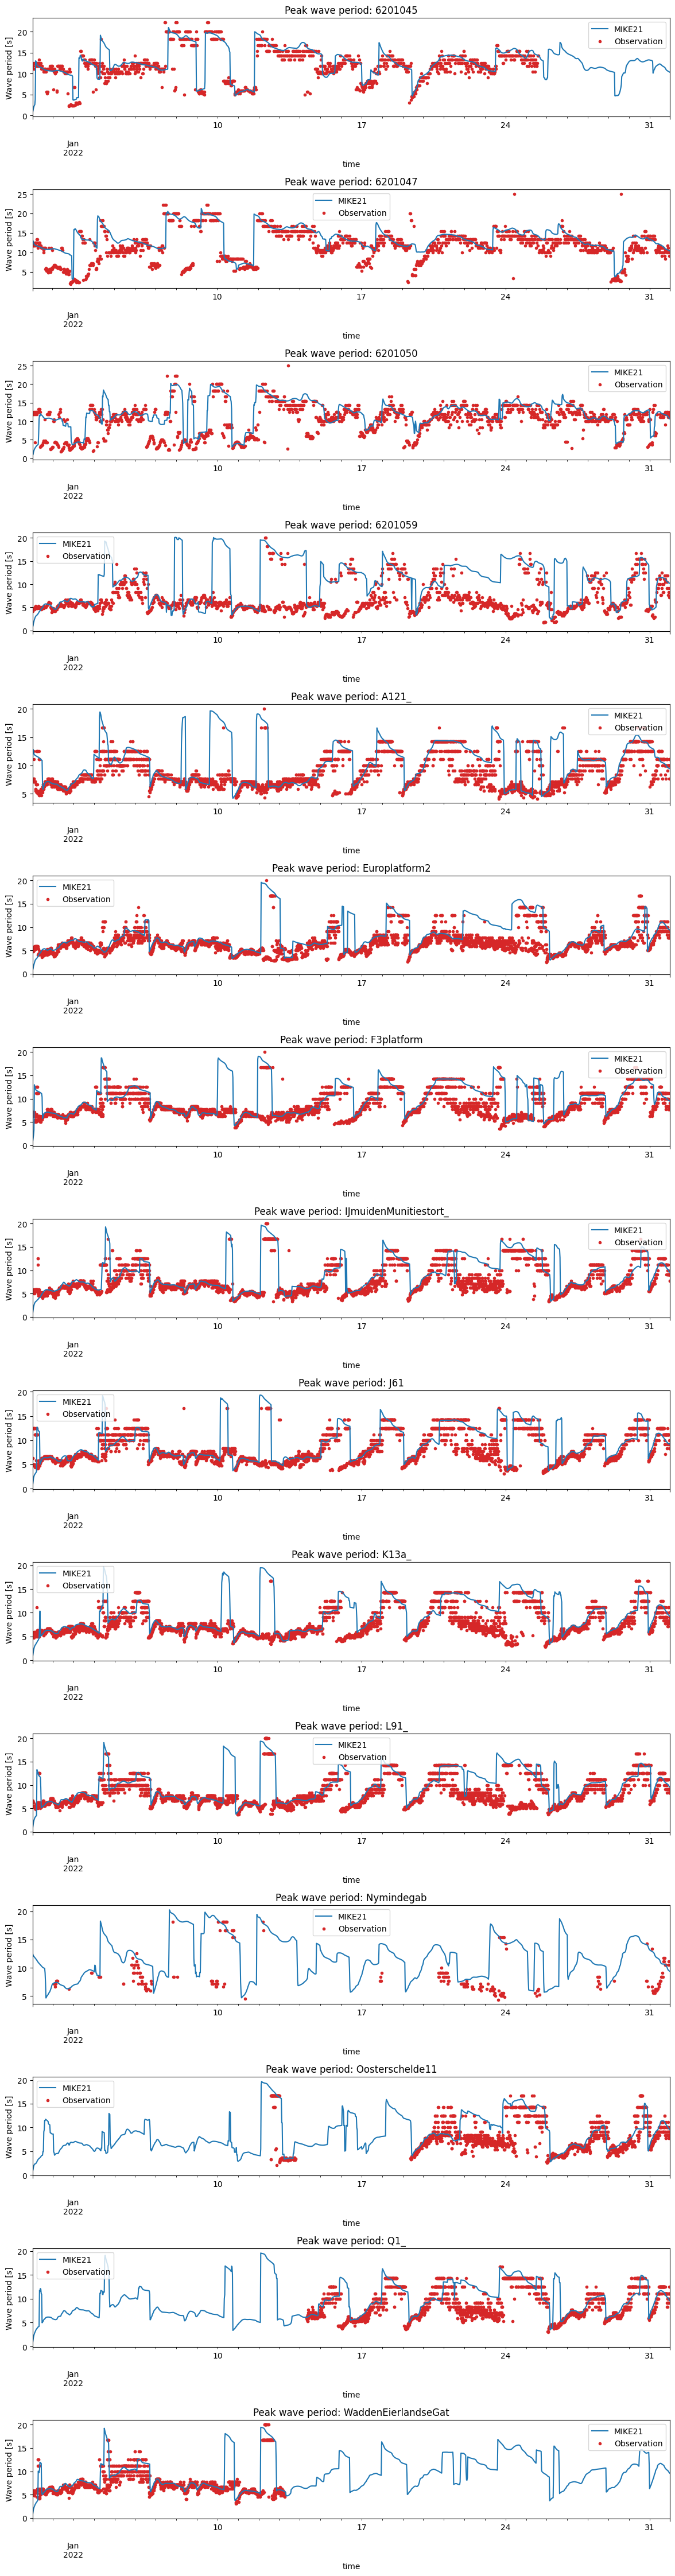

In [11]:
pl.plot_timeseries_currents(cc = cc_tp, title='Peak wave period')

## KDE plot

### Mean wave direction

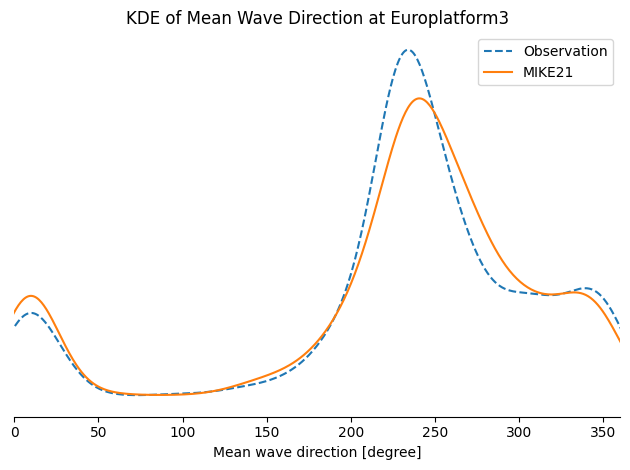

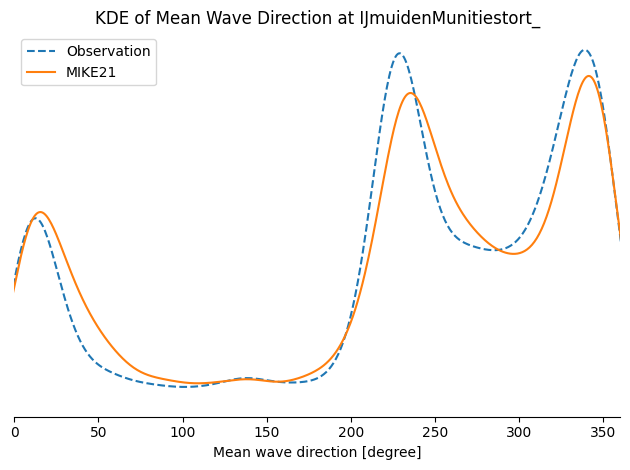

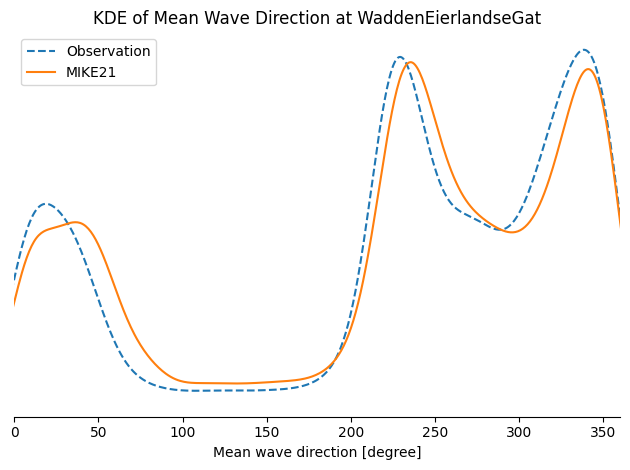

In [39]:
for cc in cc_mwd:
    ax = cc.plot.kde(xlim=(0, 360))
    ax.set_title(f"KDE of Mean Wave Direction at {cc.name}")
    plt.tight_layout()
plt.show()